In [1]:
!pip install -q einops peft open_clip_torch protobuf sentencepiece iv2-utils

DEPRECATION: Loading egg at /opt/miniconda3/lib/python3.12/site-packages/pyFluidSynth-1.3-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [1]:
import sys
import os

sys.path.append(os.getcwd())
import numpy as np
import os
import io
import cv2

import torch

from demo.config import (Config,
                    eval_dict_leaf)

from demo.utils import (retrieve_text,
                  _frame_from_video,
                  setup_internvideo2)

from iv2_utils.iv2 import *

/home/ruo/miniconda3/envs/internvideo/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/ruo/miniconda3/envs/internvideo/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


[2025-07-08 00:41:01,392] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/ruo/miniconda3/envs/internvideo/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/ruo/miniconda3/envs/internvideo/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda-12.8/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ruo/miniconda3/envs/internvideo/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda-12.8/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ruo/miniconda3/envs/internvideo/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda-12.8/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ruo/miniconda3/envs/internvideo/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda-12.8/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ruo/miniconda3/envs/internvideo/compiler_compat/ld: /usr/local/cuda-12.8/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtim

[2025-07-08 00:41:01,974] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [2]:
config = Config.from_file('scripts/evaluation/clip/zero_shot/B14/config_k400.py')
config = eval_dict_leaf(config)
config.device = 'mps'

# Regular sized model
# config.model.text_ckpt_path = 'model/internvl_c_13b_224px.pth'
# config.model.vision_ckpt_path = 'model/InternVideo2.pt'
# config.model.tokenizer_path = 'model/chinese_alpaca_lora_7b'
# config.model.text_encoder.llama_path = 'model/chinese_alpaca_lora_7b'
# config.model.extra_ckpt_path = "model/1B_clip.pth"

# Small Model
config.model.vision_ckpt_path = "model_b14/B14.bin"
config.model.text_ckpt_path = "model_b14/mobileclip_blt.pt"
config.model.extra_ckpt_path = "model_b14/1B_clip.bin"


# model_pth = 'model/InternVideo2.pt'
# config['pretrained_path'] = model_pth
# config['model']['vision_encoder']['pretrained'] = model_pth
# config['model']['extra_ckpt_path'] = 'model/1B_clip.pth'

In [3]:
from models.internvideo2_clip_small import InternVideo2_CLIP_small
intern_model = InternVideo2_CLIP_small(config)

/Users/qing/PycharmProjects/InternVideo/InternVideo2/multi_modality/models/internvideo2_clip_small.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vision_ckpt = torch.

In [4]:
import torch
total_params = sum(p.numel() for p in intern_model.parameters())

print(f'Total number of parameters: {total_params:,}')

Total number of parameters: 153,262,337


In [ ]:
intern

In [5]:
import pandas as pd
import numpy as np

val_data = pd.read_csv('k600/val.csv').iloc[:,0:2]
videos = os.listdir('k600/part_0')

print(val_data.head())
print()
print(videos[-5:])

id_label_map = {}
for row in range(len(val_data)):
    id_label_map[val_data.iloc[row]['youtube_id']] = val_data.iloc[row]['label']

remove_points = len(videos) - 500
sampled_points = np.random.choice(videos, remove_points, replace=False)
classes = val_data['label'].unique()
for i in sampled_points:
    os.remove(f'k600/part_0/{i}')
print(f"Removed {remove_points} Videos!")

       label   youtube_id
0  abseiling  0wR5jVB-WPk
1  abseiling  3caPS4FHFF8
2  abseiling  3yaoNwz99xM
3  abseiling  6IbvOJxXnOo
4  abseiling  6_4kjPiQr7w

['-j3eNzQR-EI_000064_000074.mp4', '-C-PvafuvFE_000068_000078.mp4', '0yNXOIqJLtA_000012_000022.mp4', '13Ub1MDkiHc_000014_000024.mp4', '-IlFdaVdEyU_000001_000011.mp4']
Removed 0 Videos!


In [14]:
gif87_dir = '../../../photography-model/GIF87'
output_dir = 'output'

gif87_anno = pickle_read(os.path.join(gif87_dir, '../rustyjar/GIF87-anno.pkl'))
phrases = [x[1][1] for x in gif87_anno]
print(phrases[:5])

['woman falls down', 'woman falls down', 'guy falls down onto couch', 'person falls down', 'guy falls down']


In [11]:
phrases = [x[1] for x in pickle_read('../../../photography-model/rustyjar/STOCK100.pkl')]
print(phrases[:5])

['A small kid falls down onto the ground.', 'A brown horse jumps over the hurdle.', 'A kid splashes into the water.', 'A dog splashes into the water.', 'A person splashes into the pool.']


In [5]:
bruh = torch.device('mps')

In [6]:
bruh.type

'mps'

In [13]:
video = cv2.VideoCapture('../../../photography-model/ACT75/1.mp4')
phrase = "A person runs off a roof, jumping into the pool and making a huge splash."
frames = [x for x in _frame_from_video(video)]
texts, probs = retrieve_text(frames, [phrase], model=intern_model, topk=1, config=config, device = torch.device("mps"))

In [12]:
probs

array([26.429283], dtype=float32)

In [5]:
from tqdm.notebook import tqdm

logits = []
preds  = []

gif87_dir = '../../../photography-model/GIF100'
output_dir = 'output'
for check in tqdm(range(1, 101)):
    split_video_to_mp4(os.path.join(gif87_dir, f'{check}.mp4'), output_dir=output_dir, window_size=8)

    logit_curr = []
    pbar = tqdm(get_output_dir(output_dir))
    for j in pbar:
        video = cv2.VideoCapture(j)
        pbar.set_description(j)
        frames = [x for x in _frame_from_video(video)]
    
        phrase = phrases[check - 1]
        
        texts, probs = retrieve_text(frames, [phrase], model=intern_model, topk=1, config=config, device = "mps")
        logit_curr.append(probs[0])
    preds.append(np.argmax(logit_curr) + 1)
    logits.append(list(zip(logit_curr, range(1, len(logit_curr) + 1))))

print(preds[:5])
pickle_write(preds, 'stock100-preds.pkl')
pickle_write(logits, 'stock100-logits.pkl')

  0%|          | 0/100 [00:00<?, ?it/s]

OpenCV: Couldn't read video stream from file "../../../photography-model/GIF100/1.mp4"


0it [00:00, ?it/s]

ValueError: attempt to get argmax of an empty sequence

In [9]:
from tqdm.notebook import tqdm

logits = []
preds  = []
for check in tqdm(range(1, 51)):
    split_video_to_mp4(os.path.join('../../../photography-model/backflip', f'{check}.mp4'), output_dir=output_dir, window_size=8)

    logit_curr = []
    pbar = tqdm(get_output_dir(output_dir))
    for j in pbar:
        video = cv2.VideoCapture(j)
        pbar.set_description(j)
        frames = [x for x in _frame_from_video(video)]
        
        texts, probs = retrieve_text(frames, ['A person performing a backflip.'], model=intern_model, topk=1, config=config, device = "cpu")
        logit_curr.append(probs[0])
    preds.append(np.argmax(logit_curr) + 1)
    logits.append(list(zip(logit_curr, range(1, len(logit_curr) + 1))))

print(preds[:5])
pickle_write(preds, 'preds-r.pkl')
pickle_write(logits, 'logits-r.pkl')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
from IPython.display import clear_output
top1 = 0
top5 = 0
total = 0
collect_data = []
for check in videos:
    video = cv2.VideoCapture(f'k600/part_0/{check}')
    frames = [x for x in _frame_from_video(video)]
    
    video_label = id_label_map[check[:11]]
    
    texts, probs = retrieve_text(frames, classes, model=intern_model, topk=5, config=config, device = "cpu")
    collect_data.append((texts, probs))
    clear_output(wait=True)
    if texts[0] == video_label:
        top1 += 1
    if video_label in texts:
        top5 += 1
    total += 1
    print(f"{total}/500 Completed")
    print('-'*25)
    print("Correct:", video_label)
    print('-'*25)
    print('Predictions ' + '-'*13)
    for i, v in zip(texts, probs):
        print(f'{v:.4f}', '|', i)
    print('-'*25)
    print("Top 1:",top1/total)
    print("Top 5:", top5/total)

23/500 Completed
-------------------------
Correct: counting money
-------------------------
Predictions -------------
19.8364 | counting money
12.1297 | using computer
11.9010 | auctioning
10.9561 | tossing coin
9.4168 | vault
-------------------------
Top 1: 0.7391304347826086
Top 5: 0.8695652173913043


KeyboardInterrupt: 

$$\Large \textbf{Before-After}$$

------------

In [50]:
import os
import google.generativeai as genai
from IPython.display import display, Markdown, Latex

genai.configure(api_key="")
gemini = genai.GenerativeModel("gemini-1.5-flash")

In [57]:
def before_after(text):
    chat = gemini.start_chat(
        history=[
            {"role": "user", "parts": 'When you answer a question, please be concise and only answer with a single sentence.'},
        ]
    )
    before = chat.send_message(f"Given the action '{text}', create a new action that describes the moments up until '{text}' occurs.").text
    
    chat = gemini.start_chat(
        history=[
            {"role": "user", "parts": 'When you answer a question, please be concise and only answer with a single sentence.'},
        ]
    )
    after = chat.send_message(f"Given the action '{text}', create a new action that describes the moments after '{text}' occurs.").text
    return (before, after)

In [62]:
now = "A dog catching a frisbee midair."
before, after = before_after(now)
before = before.strip()
after = after.strip()

In [65]:
split_video_to_mp4('../../../photography-model/ACT75/8.mp4', 'output', window_size=8)
clips = get_output_dir('output')

prob_data = []
for clip in tqdm(clips):
    video = cv2.VideoCapture(clip)
    frames = [x for x in _frame_from_video(video)]
    
    texts, probs = retrieve_text(frames, [before, now, after], model=intern_model, topk=3, config=config, device = "cpu")
    prob_data.append(probs)

  0%|          | 0/211 [00:00<?, ?it/s]

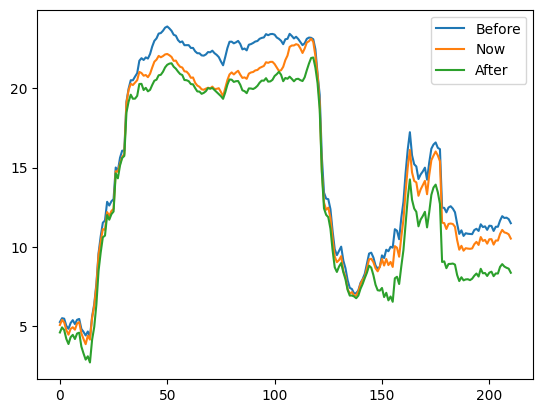

In [68]:
for phrase in range(3):
    plt.plot([x[phrase] for x in prob_data], label = "Before" if phrase == 0 else ("Now" if phrase == 1 else "After"))
plt.legend()
plt.show()

In [67]:
pickle_read('../../../photography-model/rustyjar/ACT75.pkl')[7]

('ACT75/8.mp4',
 'A dog catching a frisbee midair.',
 [53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123])